# Imports

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

from LogicalQ.Logical import LogicalCircuit, LogicalStatevector
from LogicalQ.Library.QECCs import steane_code
from LogicalQ.Library.Targets import construct_target_generic_iontrap
from LogicalQ.Library.HardwareModels import hardware_models_Quantinuum
from LogicalQ.Experiments import execute_circuits
from LogicalQ.Analysis import calculate_exp_val

# Tests

In [2]:
qec_cycle_count_list = [1,2,4,8,16,32]#list(np.arange(0, 10, 1)) #+ list(np.arange(11, 64, 2)) #[1, 2, 4, 8, 16, 32, 64]#np.arange(10) #[0, 1, 2, 3, 4, 5, 6]#, 8, 16, 32]#, 64]
lqc_list = []
qec_cycle_count_list

[1, 2, 4, 8, 16, 32]

In [3]:
lqc_base = LogicalCircuit(1, **steane_code)
lqc_base.encode([0], max_iterations=1)

[0, 1, 2]
[3, 4, 5]


True

In [4]:
for n_qec_cycles in qec_cycle_count_list:
    lqc = lqc_base.copy() #copy.deepcopy(lqc_base)
    for _ in range(n_qec_cycles):
        lqc.append_qec_cycle()
    lqc.measure_all()
    lqc_list.append(lqc)

#lqc_list[3].draw("mpl")

In [5]:
from LogicalQ.Library.Gates import RGate, RZGate, RZZGate, ZZGate

reduction = 10

faux_hardware = {
    "device_info": {
        "n_qubits": 20,
        "coupling_map": "fully_coupled",
        # "basis_gates": dict(zip(["u", "rz", "rzz", "zz"], [UGate, RZGate, RZZGate, ZZGate])),
        "basis_gates": dict(zip(["r", "rz", "rzz"], [RGate, RZGate, RZZGate])), # @TODO - TEMPORARY WORKAROUND
    },
    "noise_params": {
        "all_qubit": {
            "t1": 60 * reduction, # Decoherence times
            "t2": 4 * reduction, # Decoherence
            "gate_time": {
                1: {
                    "all": 10E-6,
                },
                2: {
                    "all": 100E-6,
                },
            },
            "readout_error": {
                1: {
                    ("0","1"): 1.22E-3 / reduction,
                    ("1","0"): 3.43E-3 / reduction,
                },
            },
            "depolarizing_error": {
                1: {
                    "all": (1-0.747) * 1.80E-5 / reduction,
                },
                2: {
                    "all": (1-0.421) * 9.73E-4 / reduction,
                },
            },
            "amplitude_damping_error": {
                1: {
                    "all": (0.747) * 1.80E-5 / reduction,
                },
                # 2: {
                #     "all": (0.421) * 9.73E-4, # @TODO - not supported by Qiskit
                # },
            },
            "dephasing_error": {
                1: {
                    # @TODO - verify angle convention (i.e. theta vs. theta/2)
                    "id": np.sin(0.122 * 10E-6**2)**2 / reduction, # Using a single-qubit gate time approximation
                }
            }
        },
    },
}

In [6]:
shots = 1E2
results = execute_circuits(
  lqc_list,
  backend="aer_simulator",
  hardware_model=hardware_models_Quantinuum['H1-1'], coupling_map=None,
  method="statevector", shots=shots
)

In [7]:
# Option 1: Logical Counts
logical_counts_list = [lqc.get_logical_counts(result.get_counts()) for lqc, result in zip(lqc_list, results)]
infidelities = [logical_counts.get("1", 0)/shots for logical_counts in logical_counts_list]

# Option 2: LogicalStatevector
# infidelities = []
# for result in results:
#     lsv = LogicalStatevector.from_counts(result.get_counts(), n_logical_qubits=1, **steane_code)
#     infidelity = 1-(lsv.logical_decomposition[0])**2
#     infidelities.append(infidelity)

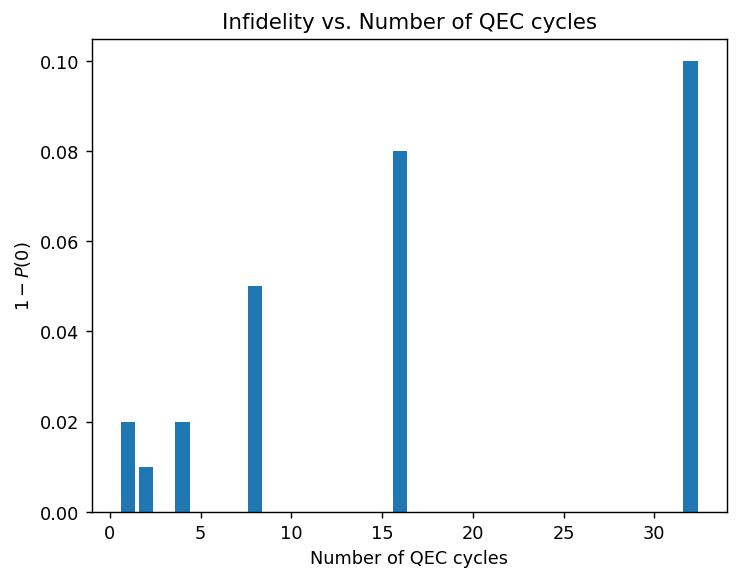

In [8]:
fig, ax = plt.subplots(dpi=128)

ax.bar(qec_cycle_count_list, infidelities)

ax.set_title("Infidelity vs. Number of QEC cycles")
ax.set_xlabel("Number of QEC cycles")
ax.set_ylabel(r"$1 - P(0)$")
# ax.set_yscale("log")

plt.show()

In [9]:
lqc_base = LogicalCircuit(1, **steane_code)
lqc_base.encode([0], max_iterations=1)
copy_base = lqc_base.copy()
dir(copy_base)


print(f"Number of qubits in lqc_base: {lqc_base.n_logical_qubits}")
print(f"Number of qubits in copy_base: {copy_base.n_logical_qubits}")

lqc_base.n_logical_qubits = 10000

print(f"Number of qubits in lqc_base: {lqc_base.n_logical_qubits}")
print(f"Number of qubits in copy_base: {copy_base.n_logical_qubits}")

[0, 1, 2]
[3, 4, 5]
Number of qubits in lqc_base: 1
Number of qubits in copy_base: 1
Number of qubits in lqc_base: 10000
Number of qubits in copy_base: 1


Quantum circuit baseline

In [10]:
shots = 1E7
from qiskit import QuantumCircuit
qc = QuantumCircuit(1)
qc.measure_all()
results = execute_circuits(
  qc,
  backend="aer_simulator",
  hardware_model=hardware_models_Quantinuum["H1-1"], coupling_map=None,
  method="statevector", shots=shots
)
counts = results[0].get_counts()
error_rate = counts['1'] / shots
print(f"Error rate: {error_rate}")

Error rate: 0.0034197


expr test

In [11]:
from qiskit.circuit.classical import expr

def cbit_and(cbits, values):
    result = expr.bit_not(cbits[0]) if values[0] == 0 else expr.lift(cbits[0])
    for n in range(len(cbits)-1):
        result = expr.bit_and(result, expr.bit_not(cbits[n+1])) if values[n+1] == 0 else expr.bit_and(result, cbits[n+1])
    return result

cbit_and([0,0,0], [1,0,0])

Binary(Binary.<Op.BIT_AND: 1>, Binary(Binary.<Op.BIT_AND: 1>, Value(0, Uint(1)), Unary(Unary.<Op.BIT_NOT: 1>, Value(0, Uint(1)), Uint(1)), Uint(1)), Unary(Unary.<Op.BIT_NOT: 1>, Value(0, Uint(1)), Uint(1)), Uint(1))

Look at circuit structure

In [12]:
n_qec_cycles = 1
lqc = lqc_base.copy() #copy.deepcopy(lqc_base)
for _ in range(n_qec_cycles):
    lqc.append_qec_cycle()
lqc.measure_all()
#lqc_list[3].draw("mpl")
lqc.decompose().draw(output='mpl')

KeyError: 1

generate_code test

In [ ]:
lqc_base = LogicalCircuit(1, **steane_code)
lqc_base.encode([0], max_iterations=1)

[0, 1, 2]
[3, 4, 5]


True

## LogicalGeneral Testing

In [2]:
qec_cycle_count_list = [1,2,4,8,16,32]#list(np.arange(0, 10, 1)) #+ list(np.arange(11, 64, 2)) #[1, 2, 4, 8, 16, 32, 64]#np.arange(10) #[0, 1, 2, 3, 4, 5, 6]#, 8, 16, 32]#, 64]
lqc_list = []
qec_cycle_count_list

from LogicalQ.LogicalGeneral import LogicalCircuitGeneral

lqc_base = LogicalCircuitGeneral(1, **steane_code)
lqc_base.encode([0], max_iterations=1)

True

In [3]:
for n_qec_cycles in qec_cycle_count_list:
    lqc = lqc_base.copy() #copy.deepcopy(lqc_base)
    for _ in range(n_qec_cycles):
        lqc.append_qec_cycle()
    lqc.measure_all()
    lqc_list.append(lqc)

In [4]:
shots = 1E3
results = execute_circuits(
  lqc_list,
  backend="aer_simulator",
  hardware_model=hardware_models_Quantinuum['H1-1'], coupling_map=None,
  method="statevector", shots=shots
)

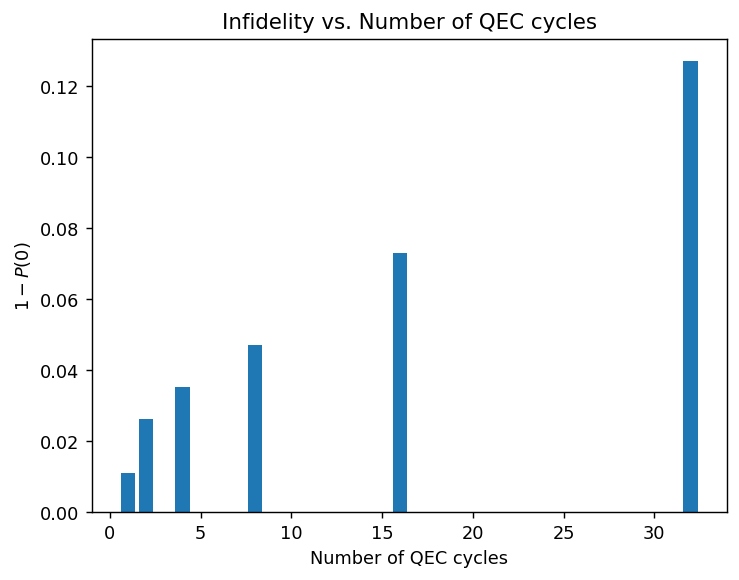

In [6]:
logical_counts_list = [lqc.get_logical_counts(result.get_counts()) for lqc, result in zip(lqc_list, results)]
infidelities = [logical_counts.get("1", 0)/shots for logical_counts in logical_counts_list]

fig, ax = plt.subplots(dpi=128)

ax.bar(qec_cycle_count_list, infidelities)

ax.set_title("Infidelity vs. Number of QEC cycles")
ax.set_xlabel("Number of QEC cycles")
ax.set_ylabel(r"$1 - P(0)$")
# ax.set_yscale("log")

plt.show()